In [1]:
import pandas
import glob
import numpy
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# preprocessing
results = []
prefixes = ['3-etcd', '6-etcd', '9-etcd']
for prefix in prefixes:
    files = glob.glob('./data/' + prefix + '*')
    df = []
    for file in files:
        d = pandas.read_csv(files[0], sep=' ', comment="{")
        d["t"] = d["time"] - d["time"].min()
        d["prefix"] = prefix
        d["file"] = file
        d = pandas.merge(d, d[d["operation"] == "deliver"], on=["processid", "messagenumber"], how="left", suffixes=('', '_y'))
        d["latency"] = d["t_y"] - d["t"]
        d = d.filter(["prefix", "file", "operation", "processid", "messagenumber", "t", "latency"])
        df.append(d)
    df = pandas.concat(df)
    average_throughput_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "deliver") & (df["t"] < 60)]["t"].astype(int)).groupby("t").size()).reset_index().rename({0: "throughput"}, axis=1)
    average_throughput_time_series["throughput"] = average_throughput_time_series["throughput"] / float(df["file"].unique().shape[0])
    average_latency_time_series = pandas.DataFrame(pandas.DataFrame(df[(df["operation"] == "broadcast") & (df["t"] < 60)])).astype({'t': 'int'}).filter(["t", "latency"]).groupby("t").mean().reset_index()
    result = {
        "prefix": prefix,
        'throughput_mean': df[ df["operation"] == "deliver"].shape[0] / (60.0 * df["file"].unique().shape[0]),
        'nodes': df["file"].unique().shape[0],
        'average_throughput_time_series': average_throughput_time_series,
        'latency_mean': df[ df["operation"] == "broadcast"]["latency"].mean(),
        'latency_std': df[ df["operation"] == "broadcast"]["latency"].std(),
        "latency_5th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.05),
        "latency_95th_quantile": df[ df["operation"] == "broadcast"]["latency"].quantile(q=0.95),
        'average_latency_time_series': average_latency_time_series,
    }
    results.append(result)
results = pandas.DataFrame(results)
results


,prefix,throughput_mean,nodes,average_throughput_time_series,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,average_latency_time_series
0,3-etcd,15313.266667,3,t throughput 0 0 7520.0 1 1 ...,0.038605,0.017383,0.020871,0.064080,t latency 0 0 0.037415 1 1 0.03...
1,6-etcd,19691.933333,6,t throughput 0 0 22656.0 1 1 ...,0.056273,0.041126,0.027246,0.101074,t latency 0 0 0.159772 1 1 0.05...
2,9-etcd,17660.000000,9,t throughput 0 0 22144.0 1 1 ...,0.083182,0.078065,0.025719,0.205007,t latency 0 0 0.129529 1 1 0.04...


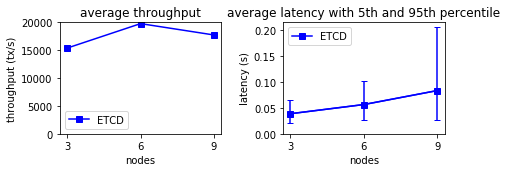

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(1.618 * 10.0 / 2.3, 5.0 / 2.0))
axs = numpy.ravel(axs)

# throughput vs nodes
ax = axs[0]
ax.plot(results["nodes"], results["throughput_mean"], label="ETCD", c="b", marker="s")
ax.set_xticks([3, 6, 9])
ax.set_ylim(bottom=0)
ax.set_ylabel("throughput (tx/s)")
ax.set_xlabel("nodes")
ax.set_title("average throughput")
ax.legend()

# latency vs nodes
ax = axs[1]
ax.plot(results["nodes"], results["latency_mean"], label="ETCD", c="b", marker="s")
ax.errorbar(results["nodes"], results["latency_mean"], [results["latency_mean"] - results["latency_5th_quantile"], results["latency_95th_quantile"] - results["latency_mean"]], c="b", label=None, capsize=3)
ax.set_xticks([3, 6, 9])
ax.set_ylim(bottom=0)
ax.set_ylabel("latency (s)")
ax.set_xlabel("nodes")
ax.set_title("average latency with 5th and 95th percentile")
ax.legend()

# make layout tolerable
plt.tight_layout()

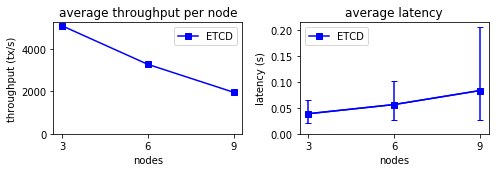

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(1.618 * 10.0 / 2.3, 5.0 / 2.0))
axs = numpy.ravel(axs)

# throughput vs nodes
ax = axs[0]
ax.plot(results["nodes"], results["throughput_mean"] / results["nodes"], label="ETCD", c="b", marker="s")
ax.set_xticks([3, 6, 9])
ax.set_ylim(bottom=0)
ax.set_ylabel("throughput (tx/s)")
ax.set_xlabel("nodes")
ax.set_title("average throughput per node")
ax.legend()

# latency vs nodes
ax = axs[1]
ax.plot(results["nodes"], results["latency_mean"], label="ETCD", c="b", marker="s")
ax.errorbar(results["nodes"], results["latency_mean"], [results["latency_mean"] - results["latency_5th_quantile"], results["latency_95th_quantile"] - results["latency_mean"]], c="b", label=None, capsize=3)
ax.set_xticks([3, 6, 9])
ax.set_ylim(bottom=0)
ax.set_ylabel("latency (s)")
ax.set_xlabel("nodes")
ax.set_title("average latency")
ax.legend()

# make layout tolerable
plt.tight_layout()

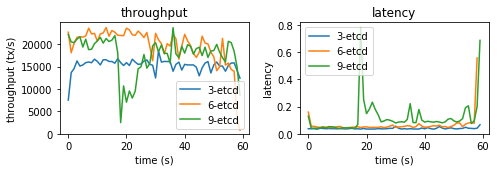

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(1.618 * 10.0 / 2.3, 5.0 / 2.0))
axs = numpy.ravel(axs)

# throughput time series
ax = axs[0]
for idx, row in results.iterrows():
    ax.plot(row["average_throughput_time_series"]["t"], row["average_throughput_time_series"]["throughput"], label=row["prefix"])
ax.set_ylim(bottom=0)
ax.set_ylabel("throughput (tx/s)")
ax.set_xlabel("time (s)")
ax.set_title("throughput")
ax.legend()

# latency time series
ax = axs[1]
for idx, row in results.iterrows():
    ax.plot(row["average_latency_time_series"]["t"], row["average_latency_time_series"]["latency"], label=row["prefix"])
ax.set_ylim(bottom=0)
ax.set_ylabel("latency")
ax.set_xlabel("time (s)")
ax.set_title("latency")
ax.legend()

# make layout tolerable
plt.tight_layout()

In [10]:
results.filter([
    "nodes", 
    "throughput_mean",
    "latency_mean",
    "latency_std",
    "latency_5th_quantile",
    "latency_95th_quantile"
])



,nodes,throughput_mean,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile
0,3,15313.266667,0.038605,0.017383,0.020871,0.064080
1,6,19691.933333,0.056273,0.041126,0.027246,0.101074
2,9,17660.000000,0.083182,0.078065,0.025719,0.205007


In [6]:
results

,prefix,throughput_mean,nodes,average_throughput_time_series,latency_mean,latency_std,latency_5th_quantile,latency_95th_quantile,average_latency_time_series
0,3-etcd,15313.266667,3,t throughput 0 0 7520.0 1 1 ...,0.038605,0.017383,0.020871,0.064080,t latency 0 0 0.037415 1 1 0.03...
1,6-etcd,19691.933333,6,t throughput 0 0 22656.0 1 1 ...,0.056273,0.041126,0.027246,0.101074,t latency 0 0 0.159772 1 1 0.05...
2,9-etcd,17660.000000,9,t throughput 0 0 22144.0 1 1 ...,0.083182,0.078065,0.025719,0.205007,t latency 0 0 0.129529 1 1 0.04...


In [7]:
# !old

In [8]:
# # preprocessing
# throughput_df = []
# latency_df = []

# prefix = ['3-etcd']
# files = glob.glob('./data/3-etcd*')

# for file in files:
#     df = pandas.read_csv(files[0], sep=' ', comment="{")
#     df["t"] = df["time"] - df["time"].min()
#     broadcastdf = df[ df["operation"] == "broadcast"]
#     deliverdf = df[ df["operation"] == "deliver"]
#     latencydf = pandas.merge(broadcastdf, deliverdf, on=["processid", "messagenumber"], how="inner")
#     latencydf["latency"] = latencydf["t_y"] - latencydf["t_x"]
#     latencydf = latencydf.filter(["t_x", "latency"])
#     latencydf = latencydf.rename({"t_x": "t"}, axis=1)
#     latency_df.append(latencydf)
#     throughputdf = pandas.DataFrame(broadcastdf.groupby(broadcastdf["t"].astype(int)).size(), columns=["throughput"]).reset_index()
#     throughputdf = throughputdf[throughputdf["t"] < 60]
#     throughput_df.append(throughputdf)
    
# latency_df = pandas.concat(latency_df)
# throughput_df = pandas.concat(throughput_df)
# throughput_df = throughput_df.groupby("t").mean().reset_index()
# latency_df.columns, throughput_df.columns

In [9]:
# fig, axs = plt.subplots(2, 3, figsize=(1.618 * 20.0 / 2.3, 15.0 / 2.0))
# axs = numpy.ravel(axs)

# # throughput time series
# ax = axs[0]
# ax.plot(throughput_df["t"], throughput_df["throughput"], label="3-ETCD", c="b")
# ax.hlines(throughput_df["throughput"].quantile(q=0.05),0,59, colors="b", linestyles="dotted")
# ax.hlines(throughput_df["throughput"].quantile(q=0.95),0,59, colors="b", linestyles="dotted")
# # ax.hlines(throughput_df["throughput"].mean(),0,59, colors="b", linestyles="dotted")
# # ax.hlines(throughput_df["throughput"].mean()+throughput_df["throughput"].std(),0,59, colors="b", linestyles="dotted")
# # ax.hlines(throughput_df["throughput"].mean()-throughput_df["throughput"].std(),0,59, colors="b", linestyles="dotted")
# # ax.hlines(throughput_df["throughput"].quantile(q=0.95),0,59, colors="b", linestyles="dotted")

# ax.set_ylim(bottom=0)
# ax.set_ylabel("throughput (tx/s)")
# ax.set_xlabel("time (s)")
# ax.legend()

# # throughput boxplot
# ax = axs[1]
# ax.boxplot(throughput_df["throughput"], showmeans=True)
# ax.set_ylabel("throughput (tx/s)")
# ax.set_xlabel("group")
# ax.set_xticklabels(['3-ETCD'])

# # throughput percentiles
# ax = axs[2]
# ax.hist(throughput_df["throughput"], bins=100, density=True, histtype='step', cumulative=True, color="b", label="3-ETCD")
# ax.set_ylabel("percentile")
# ax.set_xlabel("throughput (tx/s)")


# # throughput statistics
# print(
#     "mean:", throughput_df["throughput"].mean(),
#     "std:", throughput_df["throughput"].std(),
#     "5th quantile:", throughput_df["throughput"].quantile(q=0.05),
#     "95th quantile:", throughput_df["throughput"].quantile(q=0.95),
# )

# # latency time series
# ax = axs[3]
# grouped_latency_df = pandas.DataFrame(latency_df.groupby(latency_df["t"].astype(int)).mean(), columns=["latency"]).reset_index()
# grouped_latency_df = grouped_latency_df[grouped_latency_df["t"] < 60]
# ax.plot(grouped_latency_df["t"], grouped_latency_df["latency"], label="3-ETCD", c="b")
# ax.hlines(latency_df["latency"].quantile(q=0.05),0,59, colors="b", linestyles="dotted")
# ax.hlines(latency_df["latency"].quantile(q=0.95),0,59, colors="b", linestyles="dotted")

# ax.set_ylim(bottom=0)
# ax.set_ylabel("latency (s)")
# ax.set_xlabel("time (s)")
# ax.legend()

# # latency boxplot
# ax = axs[4]
# ax.boxplot(latency_df["latency"], showmeans=True)

# ax.set_ylabel("latency (s)")
# ax.set_xlabel("group")
# ax.set_xticklabels(['3-ETCD'])

# # latency percentiles
# ax = axs[5]
# ax.hist(latency_df["latency"], bins=100, density=True, histtype='step', cumulative=True, color="b", label="3-ETCD")
# ax.set_ylabel("percentile")
# ax.set_xlabel("latency (s)")

# # make layout tolerable
# plt.tight_layout()